In [11]:
import os
import numpy as np

In [12]:
xs = np.loadtxt("old_faithful.txt")
print(xs.shape)

(272, 2)


In [13]:
phis = np.array([0.5, 0.5])
mus = np.array([[0.0, 50.0], [0.0, 100.0]])
covs = np.array([np.eye(2), np.eye(2)])

K = len(phis)
N = len(xs)
MAX_ITER = 100
THRESHOLD = 1e-4


def multivariate_normal(x, mu, cov):
  det = np.linalg.det(cov)
  inv = np.linalg.inv(cov)
  d = len(x)
  z = 1 / np.sqrt((2 * np.pi) ** d * det)
  y = z * np.exp(-0.5 * (x - mu).T @ inv @ (x - mu))
  return y

def gmm(x, phis, mus, covs):
  K = len(phis)
  y = 0
  for k in range(K):
    phi, mu, cov = phis[k], mus[k], covs[k]
    y += phi * multivariate_normal(x, mu, cov)
  return y


def likelihood(xs, phis, mus, covs):
	eps = 1e-8
	L = 0
	N = len(xs)
	for x in xs:
		y = gmm(x, phis, mus, covs)
		L += np.log(y + eps)
	return L / N

In [14]:
current_likelihood = likelihood(xs, phis, mus, covs)
for iter in range(MAX_ITER):
	# E-step
	qs = np.zeros((N, K))
	for n in range(N):
		x = xs[n]
		for k in range(K):
			phi, mu, cov = phis[k], mus[k], covs[k]
			q = phi * multivariate_normal(x, mu, cov)
			qs[n, k] = q
		qs[n] /= np.sum(qs[n])

	# M-step
	qs_sum = np.sum(qs, axis=0)
	for k in range(K):
		# phis
		phis[k] = qs_sum[k] / N

		# mus
		c = 0
		for n in range(N):
			c += qs[n, k] * xs[n]
		mus[k] = c / qs_sum[k]

		# covs
		c = 0
		for n in range(N):
			z = xs[n] - mus[k]
			z = z[:, np.newaxis]
			c += qs[n, k] * z @ z.T
		covs[k] = c / qs_sum[k]

	# 終了判定
	print(f"{current_likelihood:.3f}")
	next_likelihood = likelihood(xs, phis, mus, covs)	
	diff = np.abs(next_likelihood - current_likelihood)
	if diff < THRESHOLD:
		break
	current_likelihood = next_likelihood
    

-16.538
-4.415
-4.357
-4.302
-4.245
-4.200
-4.164
-4.156
-4.155


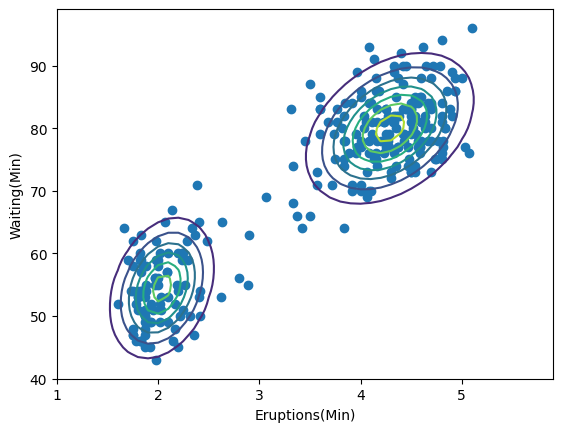

In [15]:
import matplotlib.pyplot as plt
# visualize
def plot_contour(w, mus, covs):
    x = np.arange(1, 6, 0.1)
    y = np.arange(40, 100, 1)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x = np.array([X[i, j], Y[i, j]])

            for k in range(len(mus)):
                mu, cov = mus[k], covs[k]
                Z[i, j] += w[k] * multivariate_normal(x, mu, cov)
    plt.contour(X, Y, Z)

plt.scatter(xs[:,0], xs[:,1])
plot_contour(phis, mus, covs)
plt.xlabel('Eruptions(Min)')
plt.ylabel('Waiting(Min)')
plt.show()

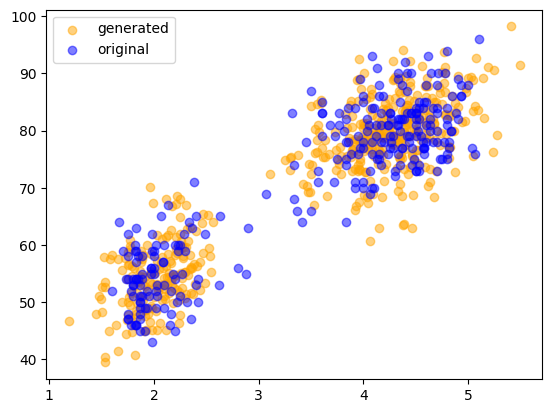

In [18]:
N = 500

new_xs = np.zeros((N, 2))
for n in range(N):
  k = np.random.choice(2, p=phis)
  mu, cov = mus[k], covs[k]
  new_xs[n] = np.random.multivariate_normal(mu, cov)
  
plt.scatter(new_xs[:,0], new_xs[:,1], label="generated", c='orange', alpha=0.5)
plt.scatter(xs[:,0], xs[:,1], label="original", c='blue', alpha=0.5)
plt.legend()